In [45]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

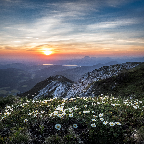

In [46]:
image=tf.keras.preprocessing.image.load_img("image 2.jpg",target_size=(144,144))
image

In [47]:
imageArray=tf.keras.preprocessing.image.img_to_array(image)

In [48]:
imageArray=imageArray[tf.newaxis,...]
print(imageArray.shape)

(1, 144, 144, 3)


In [49]:
patches=tf.image.extract_patches(imageArray,sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding='VALID')

In [50]:
print(patches.shape)

(1, 9, 9, 768)


In [51]:
patches=tf.reshape(patches,shape=(tf.shape(patches)[0],-1,16*16*3))

In [52]:
print(patches.shape)

(1, 81, 768)


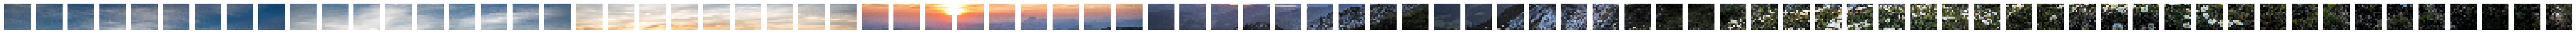

In [53]:
n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(n*n,1))

for i,patch in enumerate(patches[0]):
    ax=plt.subplot(1,n*n,i+1)
    patch_img=tf.reshape(patch,(16,16,3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis('off')

#Patch Embedding

In [54]:
class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self , size , num_of_patches , projection_dim):
    super().__init__()

    self.size = size
    self.num_of_patches = num_of_patches + 1
    self.projection_dim = projection_dim

    self.projection = tf.keras.layers.Dense(projection_dim)

    self.clsToken = tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)

    self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)
    
  
  def call(self , inputs):
    patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1] , strides=[1 , self.size , self.size , 1] , rates=[1 , 1 , 1 , 1] ,  padding="VALID")
    patches = tf.reshape(patches , (tf.shape(inputs)[0] , -1 , self.size * self.size * 3))
    patches = self.projection(patches)

    clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)

    patches = tf.concat((clsToken , patches) , axis=1)

    positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
    positionalEmbedding = self.positionalEmbedding(positions)

    patches = patches + positionalEmbedding

    return patches

In [55]:
embedding=PatchEmbedding(16,81,128)

In [56]:
result=embedding(tf.random.normal(shape=(32,144,144,3)))

In [57]:
print(result.shape)

(32, 82, 128)


#Each Layer of Transformer Encoder

In [58]:
class TransformerLayer(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.mha = tf.keras.layers.MultiHeadAttention(heads , d_model//heads , dropout=dropout_rate)

    self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.mlp = tf.keras.Sequential([
                                    tf.keras.layers.Dense(d_model * mlp_rate , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate),
                                    tf.keras.layers.Dense(d_model , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate)
    ])
  
  def call(self , inputs , training=True):
    out_1 = self.layernorm_1(inputs)
    out_1 = self.mha(out_1 , out_1 , training=training)
    out_1 = inputs + out_1

    out_2 = self.layernorm_2(out_1)
    out_2 = self.mlp(out_2 , training=training)
    out_2 = out_1 + out_2

    return out_2

In [59]:
Transformer=TransformerLayer(128,2,2)

In [60]:
Transformer(result).shape

TensorShape([32, 82, 128])

#Transformer Encoder

In [61]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
    super().__init__()

    self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]
  
  def call(self , inputs , training=True):
    x = inputs

    for layer in self.encoders:
      x = layer(x , training=training)
    
    return x

In [62]:
TransformerEncoder=TransformerEncoder(128,2,2,4)

In [63]:
TransformerEncoder(result)


<tf.Tensor: shape=(32, 82, 128), dtype=float32, numpy=
array([[[ 1.6305809 ,  1.5239071 ,  0.7907213 , ..., -0.5498734 ,
          0.05403699, -0.15890488],
        [ 0.7913059 ,  1.1912693 , -0.55696356, ...,  0.6452567 ,
         -1.8235588 ,  1.5340656 ],
        [ 0.8984915 ,  1.0186453 ,  0.6012759 , ...,  1.4016954 ,
          1.8284712 ,  1.7688401 ],
        ...,
        [ 2.177152  ,  0.21171957, -1.3038824 , ...,  3.299872  ,
          0.6132597 , -0.59780097],
        [-1.804518  ,  0.16456975, -0.87435824, ...,  0.7261544 ,
          0.9129442 ,  0.49925524],
        [ 2.2544866 ,  1.0393152 , -1.3851672 , ...,  1.8953412 ,
          1.3003613 ,  1.8376081 ]],

       [[ 1.2252951 ,  2.168462  ,  0.14919488, ...,  0.50372744,
          1.0410179 ,  1.6770957 ],
        [-2.1108558 , -0.74712557,  2.2644293 , ...,  0.7468083 ,
         -0.9232554 ,  0.32156193],
        [ 3.14509   ,  1.5863417 ,  0.7441758 , ..., -1.5409913 ,
          0.6649369 ,  1.1839875 ],
        ...,

#Vision Transformer

In [64]:
class ViT(tf.keras.Model):
  def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1 , prediction_dropout=0.3):
    super().__init__()
    
    self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
    self.encoder = TransformerEncoder(d_model , heads , mlp_rate , num_layers , dropout_rate)

    self.prediction = tf.keras.Sequential([
                                           tf.keras.layers.Dropout(prediction_dropout),
                                           tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                           tf.keras.layers.Dropout(prediction_dropout),
                                           tf.keras.layers.Dense(num_classes , activation="softmax")
    ])
  
  def call(self , inputs , training=True):
    patches = self.patchEmbedding(inputs)

    encoderResult = self.encoder(patches , training=training)

    clsResult = encoderResult[: , 0 , :]

    prediction = self.prediction(clsResult , training=training)

    return prediction

#Complete Model

In [ ]:
vitClassifier = ViT(
                    num_classes=1000,
                    patch_size=16,
                    num_of_patches=(224//16)**2,
                    d_model=128,
                    heads=2,
                    num_layers=4,
                    mlp_rate=2,
                    dropout_rate=0.1
)

#Training

In [66]:
sampleInput = tf.random.normal(shape=(1 , 224 , 224 , 3))
output = vitClassifier(sampleInput , training=False)
print(output.shape) # (1 , 1000)

(1, 1000)


In [67]:
vitClassifier.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[
                       tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                       tf.keras.metrics.TopKCategoricalAccuracy(k=5 , name="top_5_accuracy"),
              ])